---
# Size-response experiment

In [1]:
from IPython.display import Image

This notebook contains an initial analysis of 1 run (`/data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-SR_run-3_bold.mat`) of the Size-Response experiment executed on `01/02/2022`.

In this experiment, we tune the stimulus based on the obtained parameters earlier: after fitting an `iterative` fit to our `ses-1`-pRF data, we select a best vertex using `call_targetvertex`, which is embedded in `spinoza_bestvertex` that can be called easily with `master -m 18 -s <subject>`. This outputs a `model-gauss_desc-best_vertices.csv`-file in `derivatives/pycortex/<subject>`. We then do `call_sizeresponse -s <subject>`, which takes this file, applies a divise normalization (DN-) model with `iterative fit`. Internally, it assumes that the obtained pRF size is the `average across layers`. Alessio showed earlier that the pRF-size is `smaller` in the `middle` layers, so `call_sizeresponse` creates a size-response (SR-) curve for a superficial/deep pRF (defined as the pRF-size obtained with gaussian fit) and for a middle layer pRF (defined as 80% of the superficial/deep pRF size). Then, it looks for stimulus sizes where the differences between these curves are maximal, the peaks of both curves, and the intersection of the curves to obtain ~5 stimulus sizes. These stimulus sizes are then saved in a `.npy`-file in `derivatives/pycortex/<subject>` that is read in by the `sizeresponse`-experiment. 

NOTE: because the BOLD-screen was recently moved closer to the bore, we had to adapt our stimulus location/size accordingly. Below the calculation:

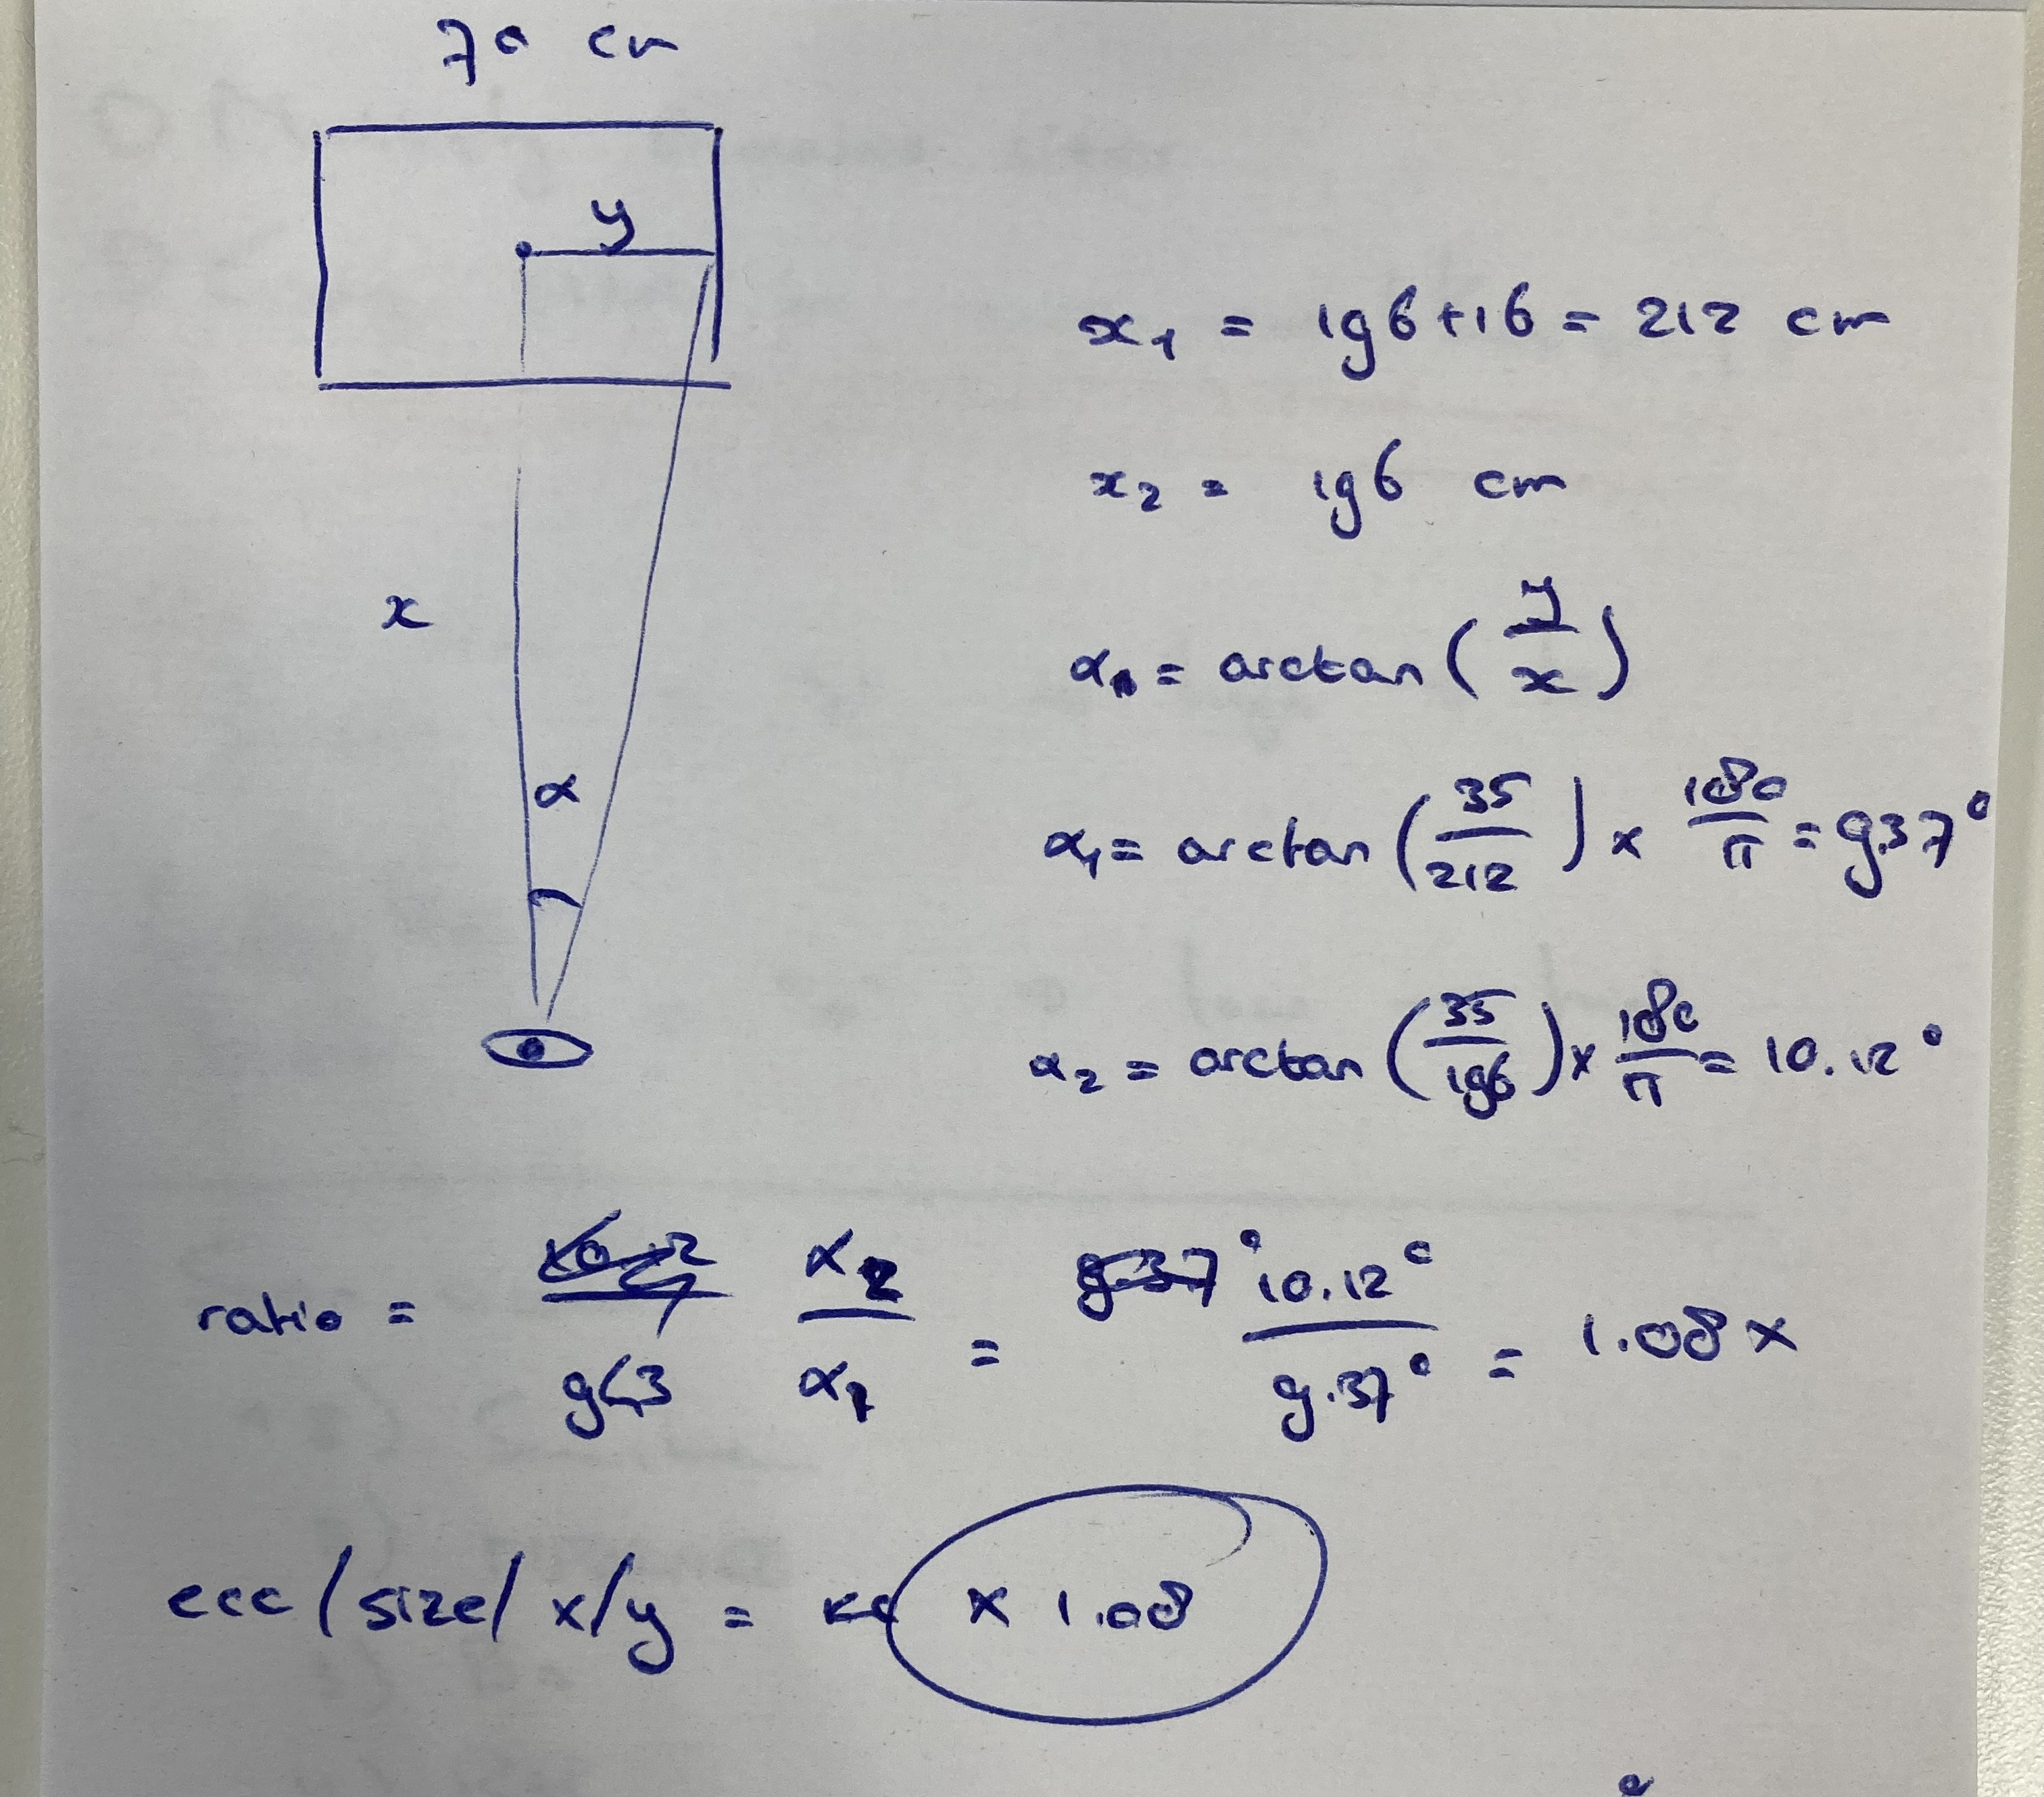

In [2]:
Image(filename="../imgs/boldscreen_increase_ratio.jpg")

This calculation shows that the x/y-location, eccentricity, and size are increased by a factor of `1.08` with the new BOLD-screen location. Therefore, the stimulus sizes and pRF-location have been updated **AFTER** running `call_sizeresponse`, so after fitting the DN-model with iterative fit.

In [3]:
%reload_ext autoreload
%autoreload 1

In [4]:
from linescanning import utils,prf,glm
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import nideconv as nd
from prfpy.stimulus import PRFStimulus2D
import os
import pandas as pd
opj = os.path.join

warnings.simplefilter('ignore')
project_dir = os.environ.get("DIR_PROJECTS")
base_dir = os.path.join(project_dir, 'hemifield')

plot_vox = 359

In [5]:
# # Load data
# sub         = '003'
# ses         = 3
# task        = "task-SR"
# run         = [1,2]

# df_func = []
# df_onsets = []
# df_physio = []
# for ix,rr in enumerate(run):
#     func_file   = opj(base_dir, f"sub-{sub}", f"ses-{ses}", "func", f"sub-{sub}_ses-{ses}_{task}_run-{rr}_bold.mat")
#     exp_file    = opj(os.path.dirname(func_file), f"sub-{sub}_ses-{ses}_{task}_run-{rr}_events.tsv")
#     physio_file = opj(os.path.dirname(func_file), f"sub-{sub}_ses-{ses}_{task}_run-{rr}_physio.txt")
#     physio_mat  = opj(os.path.dirname(func_file), f"sub-{sub}_ses-{ses}_{task}_run-{rr}_physio.mat")

#     bp_type = "rolling"
#     window = 20
#     func = utils.ParseFuncFile(func_file, 
#                             subject=1, 
#                             run=rr, 
#                             deleted_first_timepoints=200, 
#                             deleted_last_timepoints=200,
#                             bp_filter=bp_type,
#                             window_size=window)
                            
#     onset = utils.ParseExpToolsFile(exp_file,
#                                     subject=func.subject,
#                                     run=func.run,
#                                     delete_vols=(func.deleted_first_timepoints),
#                                     TR=func.TR)         

#     physio = utils.ParsePhysioFile(physio_file,
#                                 physio_mat=physio_mat,
#                                 subject=func.subject,
#                                 run=func.run,
#                                 TR=func.TR,
#                                 deleted_first_timepoints=func.deleted_first_timepoints,
#                                 deleted_last_timepoints=func.deleted_last_timepoints)

#     # Fetch dataframes
#     onset_df    = onset.get_onset_df(index=False)
#     physio_df   = physio.get_physio(index=False)
#     raw         = func.get_raw(index=False)
#     filtered    = func.dct_psc_rol.reset_index()

#     df_func.append(filtered)
#     df_onsets.append(onset_df)
#     df_physio.append(physio_df)

# df_func = pd.concat(df_func).set_index(['subject', 'run', 't'])
# df_onsets = pd.concat(df_onsets).set_index(['subject', 'run', 'event_type'])
# df_physio = pd.concat(df_physio).set_index(['subject', 'run', 't'])


Fetch the files representing the functional data (`bold.mat` > `call_linerecon`), experiment log file `events.tsv` > `exptools2`), regressor file (`physio.txt`) and mat-file (`physio.mat`) physio files (`call_spmphysio`). `run_files` collects all these files in a list, from which we can then pick the required files and store them in their respective variable

In [6]:
# Load data
sub         = '003'
ses         = 3
task        = "task-SR"
run         = 3
func_dir    = opj(base_dir, f"sub-{sub}", f"ses-{ses}", "func")

run_files   = utils.get_file_from_substring([f"sub-{sub}", f"ses-{ses}", f"{task}", f"run-{run}"], func_dir)
func_file   = utils.get_file_from_substring("bold.mat", run_files)
exp_file    = utils.get_file_from_substring("events.tsv", run_files)
physio_file = utils.get_file_from_substring("physio.txt", run_files)
physio_mat  = utils.get_file_from_substring("physio.mat", run_files)

In [7]:
bp_type = "rolling"
window = None
func = utils.ParseFuncFile(func_file, 
                           subject=1, 
                           run=1, 
                           deleted_first_timepoints=50, 
                           deleted_last_timepoints=50,
                           bp_filter=bp_type,
                           window_size=window)
                           
onset = utils.ParseExpToolsFile(exp_file,
                                subject=func.subject,
                                run=func.run,
                                delete_vols=(func.deleted_first_timepoints),
                                TR=func.TR)         

physio = utils.ParsePhysioFile(physio_file,
                               physio_mat=physio_mat,
                               subject=func.subject,
                               run=func.run,
                               TR=func.TR,
                               deleted_first_timepoints=func.deleted_first_timepoints,
                               deleted_last_timepoints=func.deleted_last_timepoints)

# Fetch dataframes
onset_df    = onset.get_onset_df(index=True)
physio_df   = physio.get_physio(index=True)
raw         = func.get_raw(index=True)
filtered    = func.dct_psc_rol

# beginning of window = NaN
print(f"Func data has shape {filtered.shape}")
print(f"Physio has shape    {physio_df.shape}")
filtered.head(10)

Func data has shape (4300, 720)
Physio has shape    (4300, 7)


vox 0      vox 1      vox 2      vox 3      vox 4  \
subject run t                                                              
1       1   0.000 -13.891742  18.961040   2.063555   3.682374  18.408554   
            0.105   2.888111   1.986200   0.264139 -19.847313  10.156828   
            0.210  14.478710   3.458475 -10.143950  12.808427   2.470381   
            0.315  -0.892761   2.037522   9.948232  10.508973   2.991287   
            0.420  -2.172973 -12.968266  -5.167143  19.498413  -3.685570   
            0.525 -23.737818  -7.576141   7.162453  -0.221609 -10.969645   
            0.630   8.424328  -8.811273  -1.871115  12.586882  13.772416   
            0.735  -8.592810   8.083386   9.330577 -16.129862  -0.913397   
            0.840  17.626143  -6.123670  13.147881   2.695694  -3.103193   
            0.945   7.667556  -4.996586  -5.789944 -14.599198 -11.609158   

                       vox 5      vox 6     vox 7      vox 8     vox 9  ...  \
subject run t                                                           ...   
1       1   0.000  -3.695518  -6.322668  7.888626  -0.710594  6.094123  ...   
            0.105  11.342183   0.616655  3.926540  -9.278136 -1.705915  ...   
            0.210  12.478609   1.801235 -9.651151   7.441659 -4.916455  ...   
            0.315  16.056643  15.093729  3.601104  -2.542463  8.589325  ...   
            0.420   3.078429   2.305972  1.143473   9.401456  5.093876  ...   
            0.525 -16.629700  -4.349517 -9.714051  -5.277828 -2.988197  ...   
            0.630   5.411646   5.801980  2.066326  -2.449740  0.101145  ...   
            0.735   3.426381   0.704158  7.235274  -8.043177 -7.728332  ...   
            0.840  -4.216687  -3.175056 -7.153110   2.255028 -7.749327  ...   
            0.945  -4.799948   0.789650  2.024322  12.618309  6.354205  ...   

                     vox 710    vox 711    vox 712    vox 713    vox 714  \
subject run t                                                              
1       1   0.000  -5.610656   1.466888 -25.425249   9.925952  23.816406   
            0.105  37.625996  -1.024690  54.549576  65.410065  29.830605   
            0.210  18.496466 -39.420109 -26.193413  20.526688  30.854065   
            0.315 -19.457424  30.023703  -3.505740 -12.246127  12.542195   
            0.420  15.934171   0.570486 -42.262344  -0.495996  36.378086   
            0.525  16.810904 -17.024399  14.329826  12.623226 -16.256826   
            0.630 -18.311798   7.588483 -24.715843  21.733543  34.318859   
            0.735  -5.960031 -13.631850  -9.117133  -1.929355  22.056669   
            0.840 -45.488060  34.797413  22.312689 -14.103241   1.133004   
            0.945 -14.301282 -44.737301  -3.642431  29.711830 -27.384666   

                     vox 715    vox 716    vox 717    vox 718    vox 719  
subject run t                                                             
1       1   0.000  36.882214  -6.540277 -36.774769 -35.853073   4.625607  
            0.105 -17.018137  42.048325  44.971848 -22.749884 -24.342083  
            0.210 -31.180561 -15.022355  -7.922815 -83.307953  12.106176  
            0.315  -0.922859  28.065704  36.624054 -30.900723   3.338297  
            0.420 -20.713203  11.566335 -47.377197 -33.735947 -26.920324  
            0.525  27.755508  38.746799 -17.769457 -25.354927  28.574694  
            0.630   0.776927  22.776789 -18.505745 -32.150249  -3.543769  
            0.735 -12.682899  11.886583 -17.584934 -17.721977  -3.580889  
            0.840 -18.730558 -13.232758  44.383709 -38.286133 -27.526775  
            0.945 -30.365932 -21.274626  -5.048028 -28.795099  62.181484  

[10 rows x 720 columns]

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


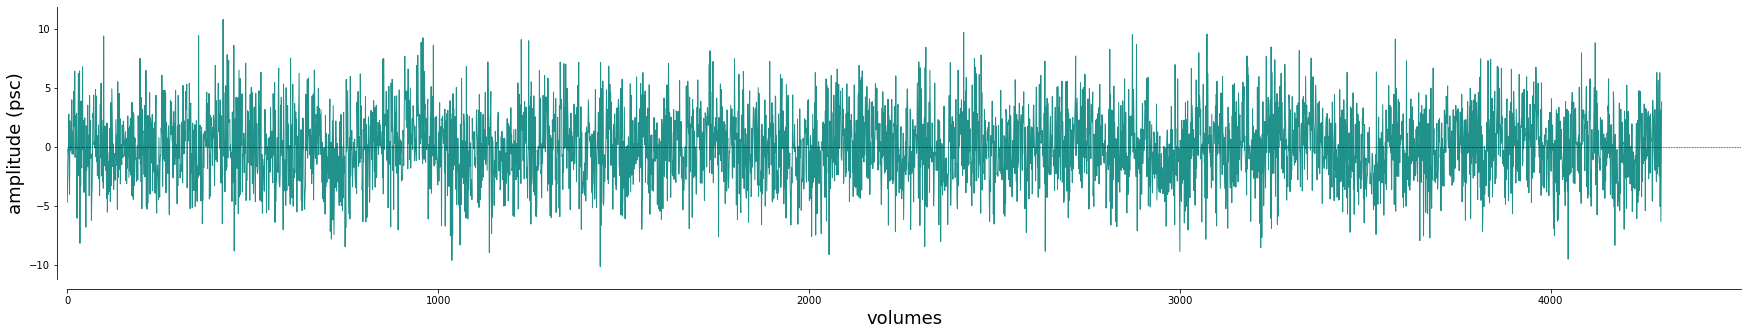

In [8]:
utils.LazyPlot(filtered[f'vox {plot_vox}'].values, 
               figsize=(30,5),
               x_label="volumes",
               y_label="amplitude (psc)",
               add_hline={'pos': 0, 'ls': '--', 'color': 'k', 'lw': 0.5},
               set_xlim_zero=True,
               sns_trim=False,
               font_size=18)


Mean heart rate = -0.0


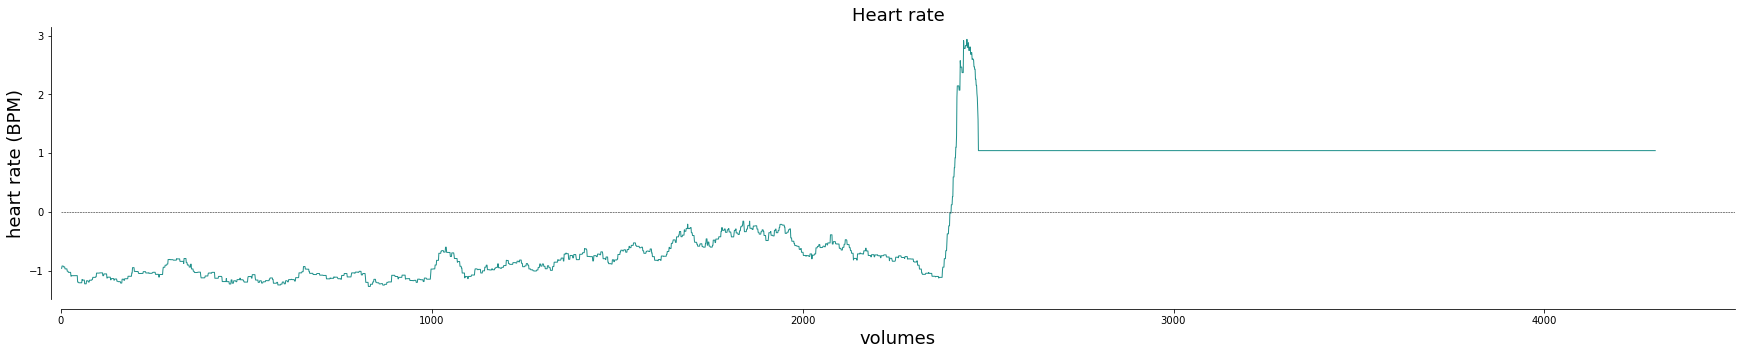

In [9]:
utils.LazyPlot(physio_df['hr'].values, 
               figsize=(30,5),
               x_label="volumes",
               y_label="heart rate (BPM)",
               title=f"Heart rate",
               add_hline={'pos': physio_df['hr'].values.mean(), 'ls': '--', 'color': 'k', 'lw': 0.5},
               set_xlim_zero=True,
               sns_trim=False,
               font_size=18)

print(f"Mean heart rate = {round(physio_df['hr'].values.mean(),2)}")

In [10]:
physio_df

c_0       c_1       r_0       r_1  cr_0  cr_1  \
subject run t                                                             
1       1   0.000    0.983301 -0.181986  0.933762 -0.357893   0.0   0.0   
            0.105    0.889547  0.456844  0.582586  0.812769   0.0   0.0   
            0.210    0.404783  0.914413 -0.672301  0.740278   0.0   0.0   
            0.315   -0.247448  0.968901 -0.877539 -0.479505   0.0   0.0   
            0.420   -0.801414  0.598111  0.284528 -0.958668   0.0   0.0   
...                       ...       ...       ...       ...   ...   ...   
            450.975  0.987050  0.160411  0.948536  0.316668   0.0   0.0   
            451.080 -0.013425  0.999910 -0.999640 -0.026848   0.0   0.0   
            451.185 -0.987050  0.160411  0.948536 -0.316668   0.0   0.0   
            451.290 -0.303905 -0.952702 -0.815283  0.579062   0.0   0.0   
            451.395  0.885456 -0.464723  0.568065 -0.822984   0.0   0.0   

                           hr  
subject run t                  
1       1   0.000   -0.957251  
            0.105   -0.957251  
            0.210   -0.957251  
            0.315   -0.918410  
            0.420   -0.918410  
...                       ...  
            450.975  1.043258  
            451.080  1.043258  
            451.185  1.043258  
            451.290  1.043258  
            451.395  1.043258  

[4300 rows x 7 columns]

---
# Deconvolution

Here we fetch relevant pRF-parameters that are required to construct the size-response curve below (this is the same curve as in `derivatives/pycortex/<subject>/<subject>_hemi-?_desc-prf_sizeresponse.pdf`).

In [11]:
# collect subject data including Normalization parameters
subject_info = utils.CollectSubject(f"sub-{sub}", prf_dir=opj(project_dir, 'hemifield', 'derivatives', 'prf', f"sub-{sub}", 'ses-1'), cx_dir=opj(project_dir, 'hemifield', 'derivatives', 'pycortex', f"sub-{sub}"), settings='recent', hemi="lh", model="norm")

# initiate the SizeResponse class
SR = prf.SizeResponse(subject_info.prf_stim, subject_info.normalization_params, subject_info=subject_info)

# make the stimuli
SR.make_stimuli()

# make the curve
sr_curve1 = SR.make_sr_function(center_prf=True)

# stimsizes are in SR.stims_fill_sizes

Perform the deconvolution using nideconv. For now, the physio-regressors are excluded because they look unreliable (see plot of heart rate above..). There might have been something wrong with the PPU/Resp acquisition, but best to leave them out until we have a run with good physiology

In [13]:
min_int = 0
max_int = 18
n_regres = 11
fs = 1/func.TR
use_physio = False
if use_physio:
    physio_conf = physio_df.copy()
else:
    physio_conf = None

g_model = nd.GroupResponseFitter(filtered,
                                 onset_df,
                                 input_sample_rate=fs,
                                 concatenate_runs=False,
                                 confounds=physio_conf, 
                                 add_intercept=False)

cond = onset_df.reset_index().event_type.unique()
cond = np.array(sorted([i for i in cond if i != 'nan']))
print(f"Conditions are: {cond}")
[g_model.add_event(str(i),
                  basis_set='fourier',
                  n_regressors=n_regres,
                  interval=[min_int,max_int]) for i in cond]
           
# g_model.add_event(str(cond[-1]), basis_set='fir', n_regressors=None, interval=[min_int,max_int])
g_model.fit()
print("Done")

Conditions are: ['1.140879298089248' '1.853928859395028' '2.014613132977678'
 '2.13914868391734' '3.5652478065289']
Done


Here I reset the index of the deconvolution dataframe, so that I can use `.loc` to select timecourses of specific voxels based on `event type`.

In [56]:
tmp = g_model.get_subjectwise_timecourses().reset_index()
time_axis = tmp[(tmp['event type'] == cond[0])]['time'].values
tmp.head(10)

,subject,event type,covariate,time,vox 0,vox 1,vox 2,vox 3,vox 4,vox 5,...,vox 710,vox 711,vox 712,vox 713,vox 714,vox 715,vox 716,vox 717,vox 718,vox 719
0,1,1.140879298089248,intercept,0.000000,-0.302569,-0.523520,-0.725687,-0.429376,0.095458,-0.222632,...,3.871843,1.794163,-2.787165,-0.935853,-1.507720,-0.802826,-0.728570,0.600843,-1.940271,-1.771139
1,1,1.140879298089248,intercept,0.005252,-0.301083,-0.529251,-0.724368,-0.430273,0.094303,-0.215801,...,3.863413,1.778638,-2.767045,-0.930975,-1.506165,-0.795548,-0.737309,0.602502,-1.950004,-1.775242
2,1,1.140879298089248,intercept,0.010503,-0.299624,-0.534972,-0.723040,-0.431159,0.093140,-0.208995,...,3.854823,1.763002,-2.746740,-0.926050,-1.504524,-0.788301,-0.746021,0.604102,-1.959721,-1.779159
3,1,1.140879298089248,intercept,0.015755,-0.298191,-0.540682,-0.721704,-0.432033,0.091967,-0.202215,...,3.846072,1.747257,-2.726252,-0.921077,-1.502796,-0.781085,-0.754706,0.605645,-1.969423,-1.782891
4,1,1.140879298089248,intercept,0.021006,-0.296785,-0.546381,-0.720359,-0.432896,0.090786,-0.195461,...,3.837160,1.731403,-2.705582,-0.916058,-1.500980,-0.773901,-0.763363,0.607129,-1.979110,-1.786437
5,1,1.140879298089248,intercept,0.026258,-0.295404,-0.552069,-0.719005,-0.433747,0.089596,-0.188734,...,3.828089,1.715442,-2.684731,-0.910991,-1.499078,-0.766750,-0.771991,0.608555,-1.988781,-1.789797
6,1,1.140879298089248,intercept,0.031509,-0.294051,-0.557745,-0.717642,-0.434586,0.088398,-0.182033,...,3.818858,1.699375,-2.663702,-0.905876,-1.497089,-0.759632,-0.780588,0.609923,-1.998435,-1.792970
7,1,1.140879298089248,intercept,0.036761,-0.292724,-0.563410,-0.716271,-0.435414,0.087192,-0.175360,...,3.809468,1.683203,-2.642496,-0.900715,-1.495013,-0.752548,-0.789155,0.611232,-2.008074,-1.795956
8,1,1.140879298089248,intercept,0.042012,-0.291424,-0.569062,-0.714891,-0.436229,0.085977,-0.168715,...,3.799918,1.666928,-2.621114,-0.895506,-1.492850,-0.745498,-0.797689,0.612483,-2.017695,-1.798754
9,1,1.140879298089248,intercept,0.047264,-0.290151,-0.574702,-0.713503,-0.437033,0.084754,-0.162098,...,3.790210,1.650551,-2.599559,-0.890251,-1.490601,-0.738483,-0.806191,0.613675,-2.027299,-1.801365


Below is the procedure for getting the average response across the ribbon in response to the different stimulus sizes. First, I specify the voxels that are part of the cortical ribbon, eg., `[356,364]`. Then, I loop through the voxel IDs, extract the HRF-timecourse, and average this. Because of the list-nature of the output, I can use `LazyPlot` quite easily to plot it. I also extract the `maximum value` of the `averaged HRF` to plot on the size-response function. Ideally, this should lie, in order from smallest stimulus size to largest stimuls size, on the size response curve.

In [65]:
ribbon      = [356,364]
stim_avg    = []
for sizes in cond:

    # stimulus-specific average
    voxel_avg = []
    for ii in range(*ribbon):
        
        tc = tmp[(tmp['event type'] == str(sizes))][f'vox {ii}'].values
        tc = np.array(tc)
        voxel_avg.append(tc)

    # average over voxels
    voxel_avg = np.array(voxel_avg).mean(axis=0)
    stim_avg.append(voxel_avg)

# normalize HRFs
voxel_avg_norm = voxel_avg/np.amax(stim_avg)

# get max amplitude so they're comparable to size-response magnitude
max_vals = np.amax(stim_avg/np.amax(stim_avg), axis=1)

The stimulus sizes on which the SR-curve is based were not corrected for the displacement of the BOLD-screen. Therefore, we need to reduce the stimulus-sizes by a factor of 1.08 (see calculation at the top of the page).

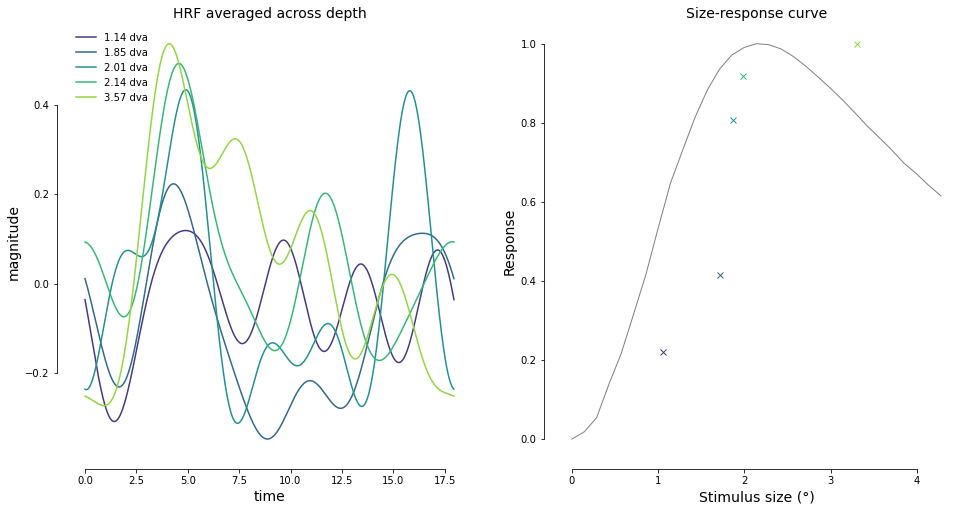

In [70]:
fig = plt.figure(figsize=(16,8))
gs = fig.add_gridspec(1,2)

ax1 = fig.add_subplot(gs[0])
utils.LazyPlot(stim_avg,
               xx=time_axis,
               axs=ax1,
               x_label="time",
               y_label="magnitude",
               font_size=14,
               title="HRF averaged across depth",
               line_width=1.5,
               figsize=(8,8),
               labels=[f"{round(float(ii),2)} dva" for ii in cond])

ax2 = fig.add_subplot(gs[1])
utils.LazyPlot(sr_curve1, 
               xx=SR.stims_fill_sizes,
               color=(128/255, 128/255, 128/255),
               axs=ax2,
               y_label="Response",
               x_label="Stimulus size (°)",
               title="Size-response curve",
               font_size=14)

cols = sns.color_palette('viridis', len(cond))
for ix,kk in enumerate(max_vals):
    ax2.plot(cond.astype(float)[ix]/1.08, kk, color=cols[ix], marker='x')               

Above we can see pretty decent HRF-responses in the left panel. We see that the largest stimulus size evokes the largest HRF with smaller stimulus sizes having lower HRF amplitudes. Despite that this is expected, I think it's still cool and promising. As for the SR-curve, we can see that the order is correct: smaller stimulus sizes = lower HRF. However, the normalized amplitudes are somewhat shifted compared to where we expected them to be based on the SR-curve.

Below I plotted the HRF for each voxel in the cortical ribbon in response to all stimulus sizes:

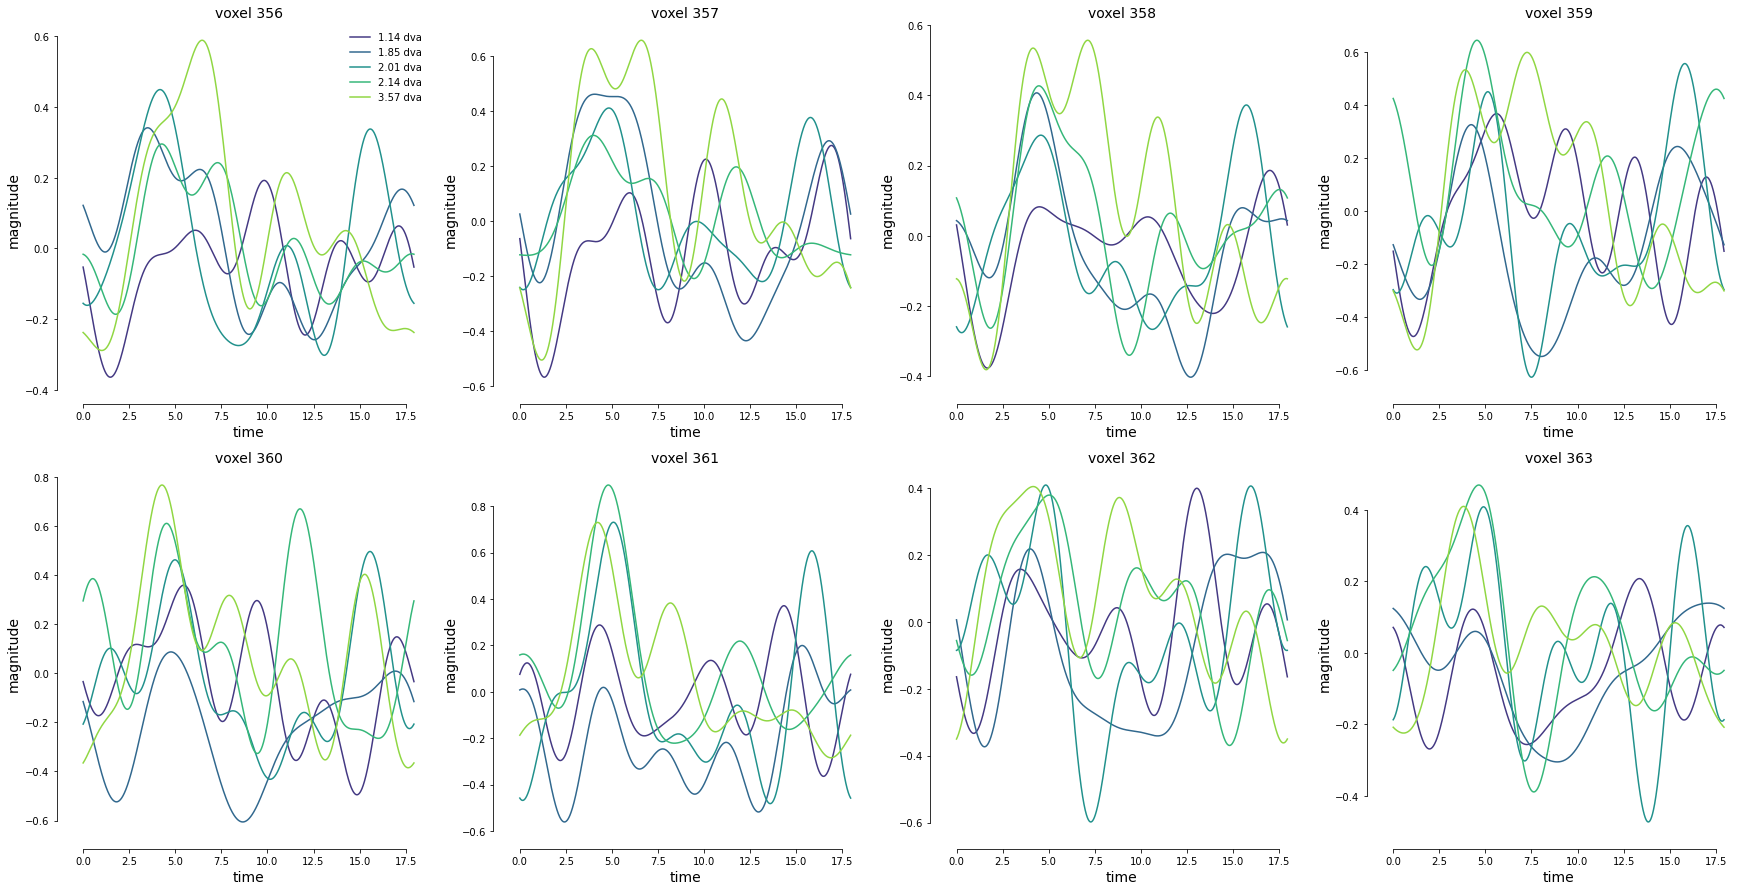

In [85]:
vox = np.arange(*ribbon)

fig = plt.figure(figsize=(30,15))
gs = fig.add_gridspec(2,len(vox)//2)
for ix,voxel in enumerate(vox):

    # fetch data from specific voxel for each stimulus size
    data = []
    for idc,size in enumerate(cond):
        vox_data = tmp[(tmp['event type'] == size)][f'vox {voxel}'].values
        data.append(vox_data)

    # draw legend once
    if ix == 0:
        labels = [f"{round(float(ii),2)} dva" for ii in cond]
    else:
        labels = None
    
    # plot all stimulus sizes for a voxel
    ax = fig.add_subplot(gs[ix])
    utils.LazyPlot(data,
                   xx=time_axis,
                   axs=ax,
                   x_label="time",
                   y_label="magnitude",
                   font_size=14,
                   title=f"voxel {voxel}",
                   line_width=1.5,
                   labels=labels)   

In [72]:
# fig = plt.figure(figsize=(16,8))
# gs = fig.add_gridspec(1,2)

# # collect data from plot_vox (default = 359)
# max_vals    = []
# vox_data    = []
# for idc,ii in enumerate(cond):

#     jj = tmp[(tmp['event type'] == str(ii))][f'vox {plot_vox}'].values
#     xx = tmp[(tmp['event type'] == str(ii))]['time'].values
#     vox_data.append(jj)
#     max_vals.append(np.amax(jj))

# ax1 = fig.add_subplot(gs[0])
# utils.LazyPlot(vox_data, 
#                xx=xx, 
#                axs=ax1,
#                x_label="time",
#                y_label="magnitude",
#                font_size=12,
#                title="HRFs of different stimulus sizes",
#                line_width=1.5,
#                labels=[f"{round(float(ii),2)} dva" for ii in cond])

# ax2 = fig.add_subplot(gs[1])
# utils.LazyPlot(sr_curve1, 
#                xx=SR.stims_fill_sizes,
#                color=(128/255, 128/255, 128/255),
#                axs=ax2,
#                y_label="Response",
#                x_label="Stimulus size (°)",
#                title="Size-response curve",
#                font_size=12)

# for ix,kk in enumerate(max_vals):
#     ax2.plot(cond.astype(float)[ix], kk, color=cols[ix], marker='x')

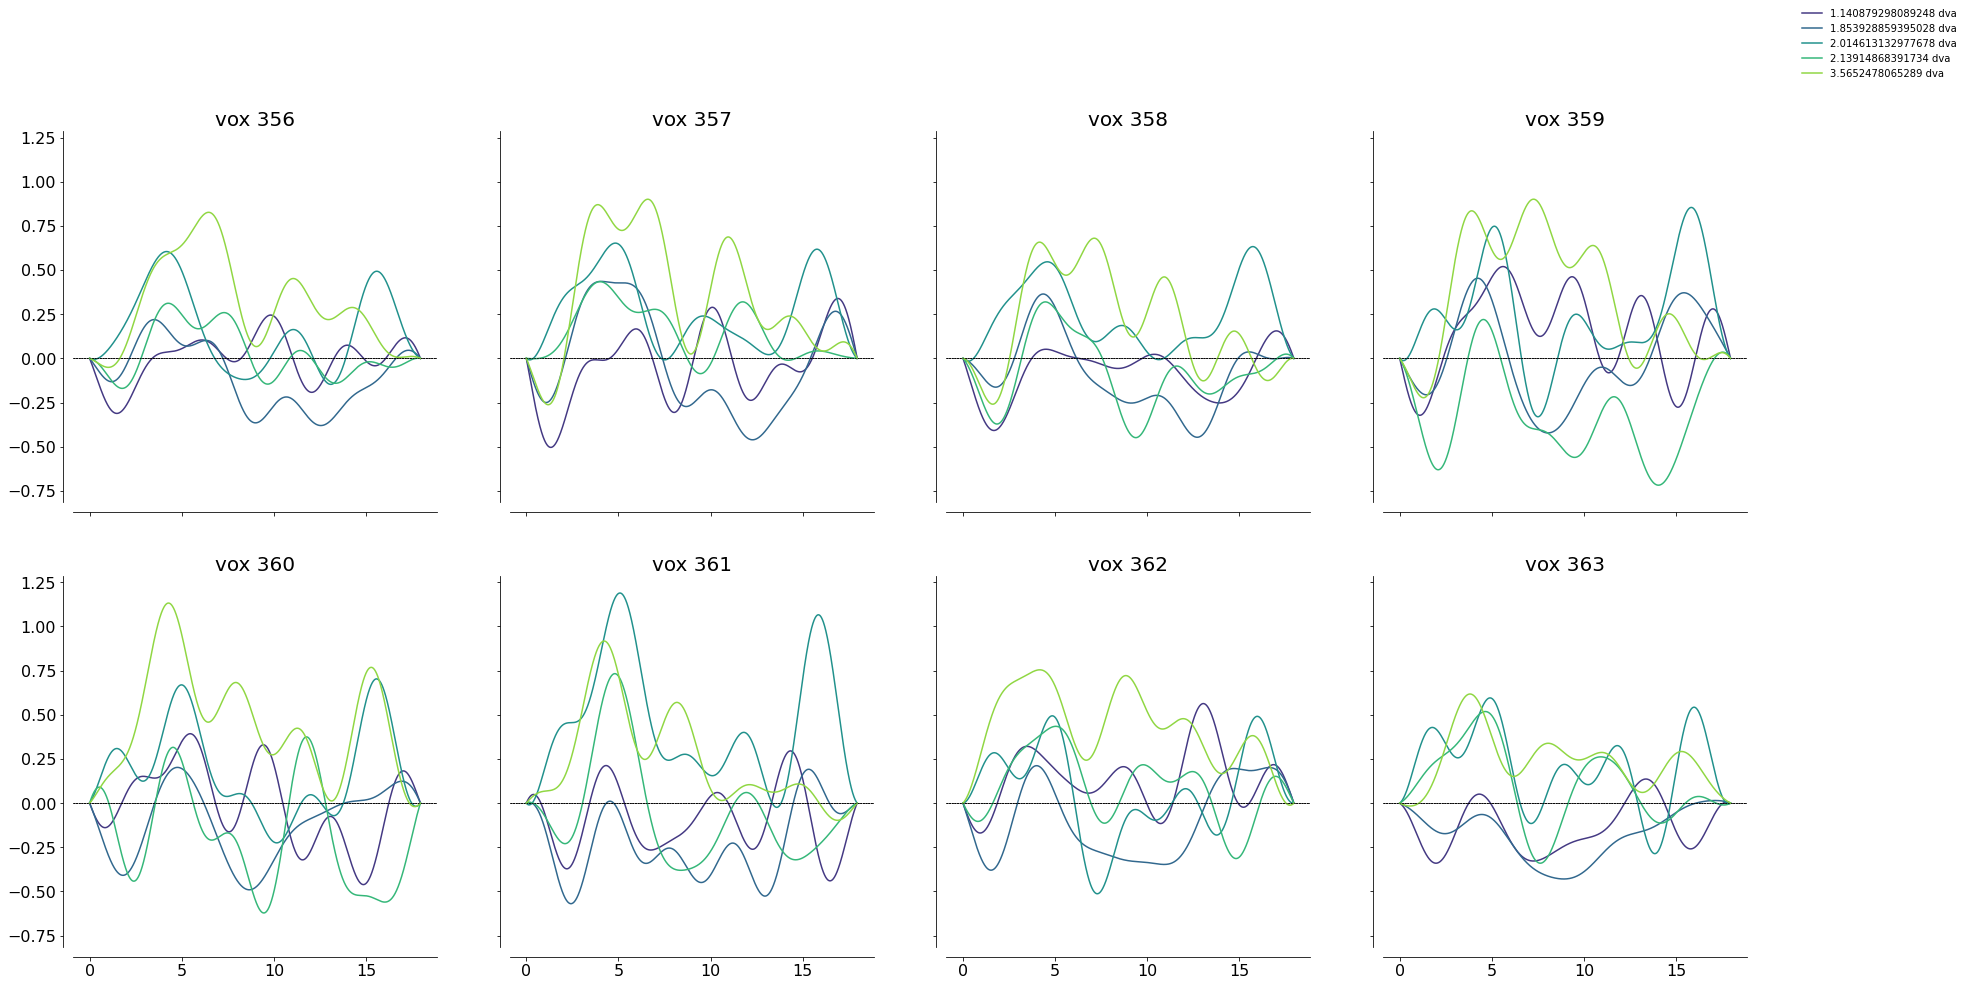

In [23]:
vox = np.arange(*ribbon)
fig, axs = plt.subplots(2, len(vox)//2, figsize=(30,15), sharex=True, sharey=True)

for i, ax in enumerate(fig.axes):
    
    for idc,ii in enumerate(cond):

        jj = tmp[(tmp['event type'] == str(ii))][f'vox {vox[i]}'].values
        xx = tmp[(tmp['event type'] == str(ii))]['time'].values

        ax.plot(xx,jj-jj[0], color=cols[idc], label=f"{str(ii)} dva")
        ax.set_title(f"vox {vox[i]}").set_fontsize(20)
        ax.axhline(0, ls='--', color='k', lw=0.5)
        ax.tick_params(axis='both', which='major', labelsize=16)
    sns.despine(offset=10)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, frameon=False)    